## Data Analitics Project - Tornadoes in US

Authors: Roman Dembrovskyi, Maciej Morgalla

In this project we try to create a model that shows in which days tornado is most likely to occur in United States. This is very important issue for everyone who lives or visits US, because tornadoes might endanger human lives. It can be aldo usefull for meteorologist in weather predicting. Finally we can predict days with tornado for next years.

Data comes from page: https://www.spc.noaa.gov/wcm/#data . Data was collected by NOAA - american government institution collecting information about weather. Data contains informations about tornadoes in years 1950-2020. Dataset contains information about: date of occurace (three separate columns respectivaly for day, month and year: dy, mo, yr),timezone and time of start and end of occurance as in form of hours-minutes-seconds, place of occurance (state and city), power of the tornado. Tornadoes power level is measured in so-called Fujita scale which divides tornadoes into different categories (F1-F5) based on the speed of wind in the epicenter.

At first we download data and create dictionary that change original dates to days of year (for example: 28th of February -> 59th day of year).

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import arviz as az
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

w=pd.read_csv("1950-2020_all_tornadoes.csv")

x=np.linspace(1,366,366)

year={}
year['1']=0
year['2']=31
year['3']=59
year['4']=90
year['5']=120
year['6']=151
year['7']=181
year['8']=212
year['9']=243
year['10']=273
year['11']=304
year['12']=334

Now we can check how many tornadoes occured in specific day of year:

Text(0, 0.5, 'Amount of tornadoes')

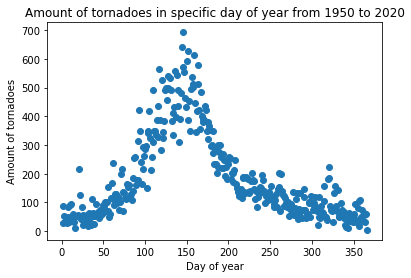

In [2]:
tornadoes=np.zeros([366])
for i in range(len(w['mo'])):
    day=int(w['dy'][i])
    month=str(w['mo'][i])
    mm=year[month]
    ww=day+mm
    if str(w['mo'][i])=='2'and str(w['dy'][i])=='29' or w['yr'][i]%4==0 and str(w['mo'][i])!='1' and str(w['mo'][i])!='2':
        ww=ww+1
    tornadoes[ww-1]=tornadoes[ww-1]+1
    
plt.plot(x,tornadoes,'o')
plt.title("Amount of tornadoes in specific day of year from 1950 to 2020")
plt.xlabel('Day of year')
plt.ylabel('Amount of tornadoes')

Unfortunately the chart is not good. There can be a day when weather condiotions where specific and more tornadoes can occur then in simple day. Thatis why we will count only days when tornado occured.

Text(0, 0.5, 'Amount of days when tornado occurred')

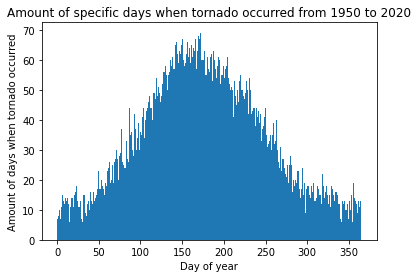

In [3]:
lista=[]
days=[]

for i in range(len(w['mo'])):
    if w['date'][i] not in lista:
        lista.append(w['date'][i])
        day=int(w['dy'][i])
        month=str(w['mo'][i])
        mm=year[month]
        ww=day+mm
        if str(w['mo'][i])=='2'and str(w['dy'][i])=='29' or w['yr'][i]%4==0 and str(w['mo'][i])!='1' and str(w['mo'][i])!='2':
            ww=ww+1
        days.append(ww-1)
        if ww==366:
            days.append(ww-1)
            days.append(ww-1)
            days.append(ww-1)
plt.hist(days,bins=366)
plt.title("Amount of specific days when tornado occurred from 1950 to 2020")
plt.xlabel('Day of year')
plt.ylabel('Amount of days when tornado occurred')

Now we have beautiful chart that shows us how many times tornado occured in x day of year from 1950 to 2020. The next step is creating two models.

## Model 1

In [4]:
with open('model1_ppc.stan') as file:
    print(file.read())


generated quantities {
    real mu=normal_rng(174,4);
    real sigma=lognormal_rng(4.4,0.04);    
    real prob = normal_rng(mu,sigma);
}


Our first model is based on a normal distribution, which is characterized by two parameters:  $\mu$ - location, $\sigma$  - scale. In order to specify $\mu$ we decided for it to be normally distributed with predefined variables, where $\mu$ was calculated by approximation of entry data. Chosen values happened to be $\mu$=174 and $\sigma$ = 4. 
Expected value of $\sigma$ lied in a margin beetwen 70 and 90. Therefore chosen approximation method was based on a lognormal distribution with specific values that granted complying results.  

In [5]:
model1_ppc=CmdStanModel(stan_file='model1_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [6]:
data=dict(N=366,torns=tornadoes)
m1=model1_ppc.sample(iter_sampling=12124,chains=1,fixed_param=True)
m1.diagnose()

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


'Processing csv files: C:\\Users\\Emperor\\AppData\\Local\\Temp\\tmpv9w4w0p7\\model1_ppc-20220620182919.csvWarning: non-fatal error reading adaptation data\n\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

While diagnosing the model, no problems were detected.

Text(0.5, 1.0, 'sigma')

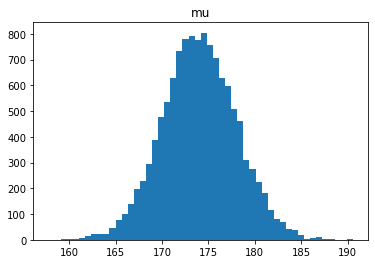

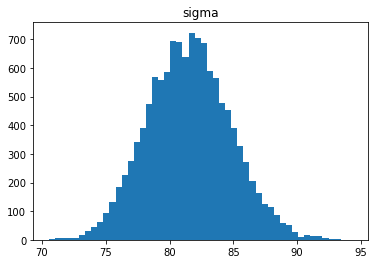

In [7]:
mu1=m1.stan_variable('mu')
sigma1=m1.stan_variable('sigma')
prob1=m1.stan_variable('prob')

plt.hist(mu1,bins=50)[2]
plt.title("mu")
plt.figure()
plt.hist(sigma1,bins=50)[2]
plt.title("sigma")

Values of $\mu$ and $\sigma$ were defined as expected.

Text(0.5, 1.0, 'Comparison between real data and generated data')

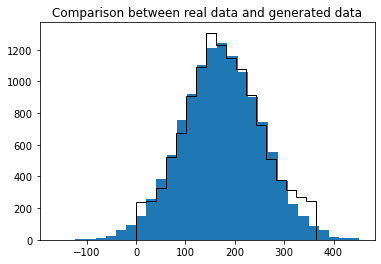

In [8]:
a=max(prob1)
b=min(prob1)

plt.hist(prob1,bins=int((a-b)/20))[2]
plt.hist(days,bins=int(366/20),histtype='step',color='black')[2]
plt.title("Comparison between real data and generated data")

Comparising of generated and real data proved that obtained variables used in data generation allowed to abide with set requirement of accuracy. 

In [9]:
with open('model1_fit.stan') as file:
    print(file.read())

data{
    int N;
    real probs[N];
}

parameters{
    real mu;
    real<lower=0> sigma;

}

model{
    mu ~ normal(174,4);
    sigma ~ lognormal(4.4,0.04);    
    probs ~ normal(mu,sigma);

}

generated quantities {
    vector[N] log_lik;
    vector[N] prob;
    
    for (i in 1:N){
        prob[i] = normal_rng(mu,sigma);
        log_lik[i] = normal_lpdf(probs[i]|mu,sigma);
        
    }
}


Model was created based on specified model distribution with previously defined variables - $\mu$ and $\sigma$.

In [10]:
model1_fit=CmdStanModel(stan_file='model1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [11]:
data=dict(N=len(days),probs=days)
m2=model1_fit.sample(data=data,iter_sampling=1000,chains=1)
m2.diagnose()

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


'Processing csv files: C:\\Users\\Emperor\\AppData\\Local\\Temp\\tmpv9w4w0p7\\model1_fit-20220620182924.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

No problems with sampling

Text(0.5, 1.0, 'sigma')

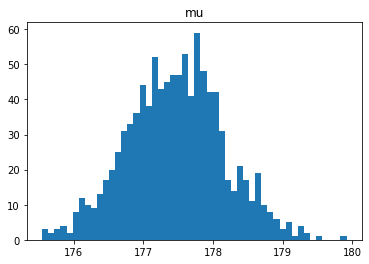

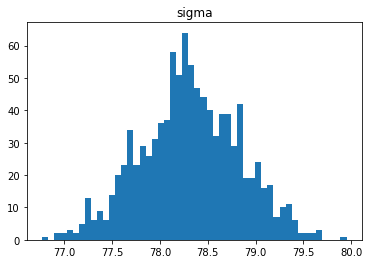

In [12]:
mu2=m2.stan_variable('mu')
sigma2=m2.stan_variable('sigma')
prob2=m2.stan_variable('prob')

plt.hist(mu2,bins=50)[2]
plt.title("mu")
plt.figure()
plt.hist(sigma2,bins=50)[2]
plt.title("sigma")

Values of $\mu$ and $\sigma$ were defined as expected.

Text(0.5, 1.0, 'Comparison between real data and generated data from model')

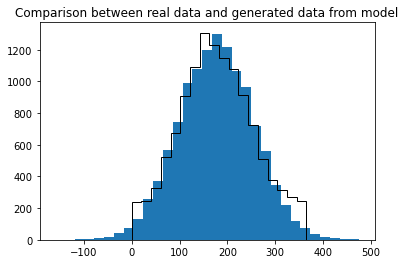

In [13]:
m=0
a=max(prob2[m])
b=min(prob2[m])

plt.hist(prob2[m],bins=int((a-b)/20))[2]
plt.hist(days,bins=int(366/20),histtype='step',color='black')[2]
plt.title("Comparison between real data and generated data from model")


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


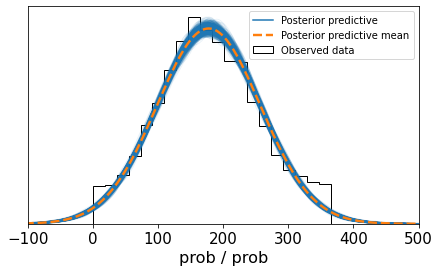

In [39]:
fitmodel1 = az.from_cmdstanpy(posterior=m2,
                           log_likelihood='log_lik',
                           posterior_predictive='prob',
                           observed_data={'prob':days})
ax=az.plot_ppc(data = fitmodel1, alpha=0.1,figsize=(7, 4),data_pairs={'days':'generated days'},num_pp_samples=1000, observed=False)
ax.set_xlim((-100,500))
ax.hist(days,bins=20,histtype='step',edgecolor='black',density=True,label='Observed data')
ax.legend()
plt.show()

All samples were quite close to originial data, what can be deduced from the graph. Comparising of generated and real data proved that obtained variables used in data generation allowed to abide with set requirement of accuracy. 
Some retrieved values were not within the range of 0 to 366, but percentage of faultage was less than 0.5%. 

# Model 2


Difference in models. The main factor that differs first and second model was in choice distribution method. Second model revolved around student_t random distribution, which also entalied usage of $\nu$ variable, that was not used previously. $\mu$ and $\sigma$ remained the same as in the previous model.

$\nu$ was defined with help of lognormal distribution with variables acquired by trial and error method to achieve satisfactory outcome.

In [17]:
with open('model2_ppc.stan') as file:
    print(file.read())

generated quantities{
    real mu=normal_rng(174,4);
    real sigma=lognormal_rng(4.4,0.04);
    real nu=lognormal_rng(2.7,0.1);
    real prob = student_t_rng(nu,mu,sigma);
}


In [18]:
model2_ppc=CmdStanModel(stan_file='model2_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [27]:
data=dict(mu1=2.7,sigma1=0.1)
m3=model2_ppc.sample(data=data,iter_sampling=12124,chains=1,fixed_param=True)
m3.diagnose()

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


'Processing csv files: C:\\Users\\Emperor\\AppData\\Local\\Temp\\tmpv9w4w0p7\\model2_ppc-20220620185110.csvWarning: non-fatal error reading adaptation data\n\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In result of model diagnostics no problems were detected.

Text(0.5, 1.0, 'nu')

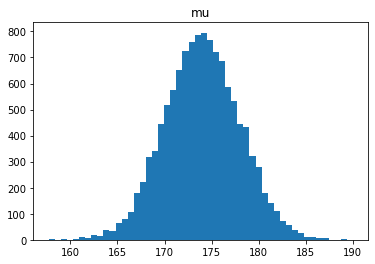

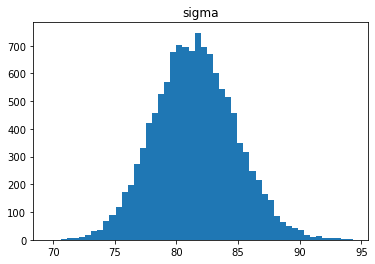

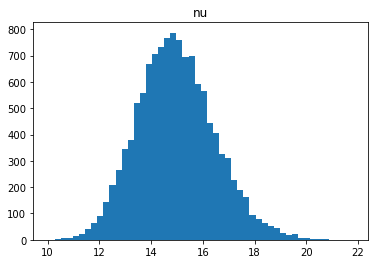

In [28]:
prob3=m3.stan_variable('prob')
mu3=m3.stan_variable('mu')
sigma3=m3.stan_variable('sigma')
nu3=m3.stan_variable('nu')

plt.hist(mu3,bins=50)[2]
plt.title("mu")
plt.figure()
plt.hist(sigma3,bins=50)[2]
plt.title("sigma")
plt.figure()
plt.hist(nu3,bins=50)[2]
plt.title("nu")

Values of $\mu$, $\nu$ and $\sigma$ were defined as expected.

Text(0.5, 1.0, 'Comparison between real data and generated data')

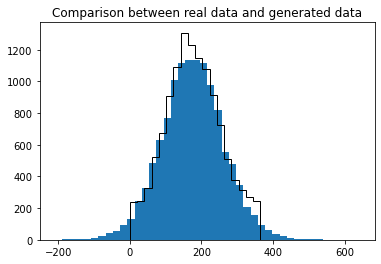

In [29]:
a=max(prob3)
b=min(prob3)

plt.hist(prob3,bins=int((a-b)/20))[2]
plt.hist(days,bins=int(366/20),histtype='step',color='black')[2]
plt.title('Comparison between real data and generated data')


Comparising of generated and real data proved that obtained variables used in data generation allowed to abide with set requirement of accuracy. 

In [30]:
with open('model2_fit.stan') as file:
    print(file.read())

data{
    int N;
    real probs[N];
}

parameters{
    real mu;
    real nu;
    real<lower=0> sigma;
}


model{
    mu ~ normal(174,4);
    sigma ~ lognormal(4.4,0.04);
    nu ~ lognormal(2.7,0.1);
    probs ~ student_t(nu,mu,sigma);

}

generated quantities {
    vector[N] log_lik;
    vector[N] prob;
    
    for (i in 1:N){
        log_lik[i] = student_t_lpdf(probs[i]|nu,mu,sigma);
        prob[i] = student_t_rng(nu,mu,sigma);
    }
    

}


Model was created based on specified model distribution with previously defined variables - $\mu$,$\nu$ and $\sigma$.

In [31]:
model2_fit=CmdStanModel(stan_file='model2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [32]:
data4=dict(N=len(days),probs=days)
m4=model2_fit.sample(data=data4,iter_sampling=1000,chains=1)
m4.diagnose()

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


'Processing csv files: C:\\Users\\Emperor\\AppData\\Local\\Temp\\tmpv9w4w0p7\\model2_fit-20220620185117.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

No problems with sampling

Text(0.5, 1.0, 'nu')

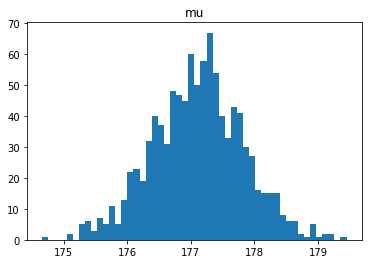

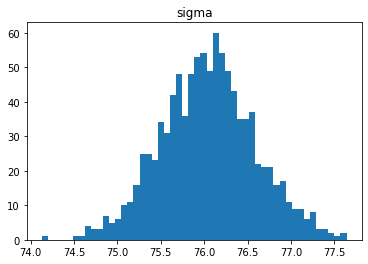

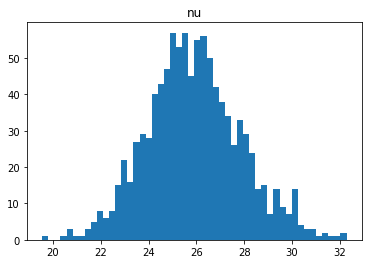

In [33]:
prob4=m4.stan_variable('prob')
mu4=m4.stan_variable('mu')
sigma4=m4.stan_variable('sigma')
nu4=m4.stan_variable('nu')

plt.hist(mu4,bins=50)[2]
plt.title("mu")
plt.figure()
plt.hist(sigma4,bins=50)[2]
plt.title("sigma")
plt.figure()
plt.hist(nu4,bins=50)[2]
plt.title("nu")

Values of $\mu$, $\nu$ and $\sigma$ were defined as expected.

Text(0.5, 1.0, 'Comparison between real data and generated data from model')

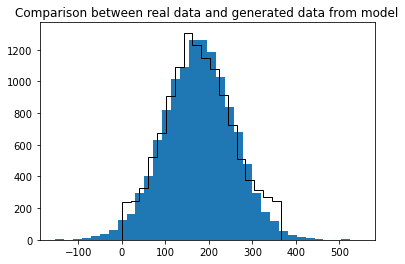

In [34]:
m=0
a=max(prob4[m])
b=min(prob4[m])

plt.hist(prob4[m],bins=int((a-b)/20))[2]
plt.hist(days,bins=int(366/20),histtype='step',color='black')[2]
plt.title("Comparison between real data and generated data from model")


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


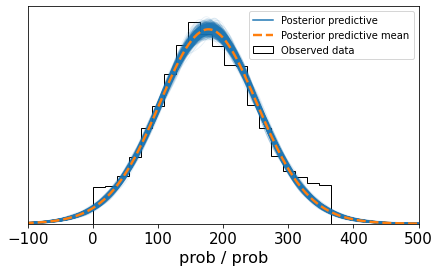

In [40]:
fitmodel2 = az.from_cmdstanpy(posterior=m4,
                           log_likelihood='log_lik',
                           posterior_predictive='prob',
                           observed_data={'prob':days})
ax=az.plot_ppc(data = fitmodel2, alpha=0.1,figsize=(7, 4),data_pairs={'days':'generated days'},num_pp_samples=1000, observed=False)
ax.set_xlim((-100,500))
ax.hist(days,bins=20,histtype='step',edgecolor='black',density=True,label='Observed data')
ax.legend()
plt.show()

All samples were quite close to originial data, what can be deduced from the graph. Comparising of generated and real data proved that obtained variables used in data generation allowed to abide with set requirement of accuracy. 

## Models comparasing

In [41]:
m2.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-59000.0,0.04300,1.000,-59000.0,-59000.0,-59000.0,550.0,5.2,1.0
mu,180.0,0.02800,0.690,180.0,180.0,180.0,600.0,5.6,1.0
sigma,78.0,0.01600,0.510,77.0,78.0,79.0,980.0,9.2,1.0
log_lik[1],-6.0,0.00043,0.011,-6.0,-6.0,-6.0,656.0,6.2,1.0
log_lik[2],-6.2,0.00048,0.012,-6.2,-6.2,-6.1,689.0,6.5,1.0
...,...,...,...,...,...,...,...,...,...
prob[12126],173.0,2.50000,78.000,44.0,173.0,299.0,938.0,8.9,1.0
prob[12127],178.0,2.50000,77.000,47.0,180.0,309.0,929.0,8.8,1.0
prob[12128],180.0,2.50000,79.000,44.0,180.0,307.0,992.0,9.4,1.0


In [42]:
m4.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-63000.0,0.06200,1.300,-63000.0,-63000.0,-63000.0,440.0,3.2,1.0
mu,180.0,0.02200,0.720,180.0,180.0,180.0,1100.0,7.6,1.0
nu,26.0,0.08100,2.000,23.0,26.0,29.0,590.0,4.2,1.0
sigma,76.0,0.01800,0.540,75.0,76.0,77.0,960.0,6.9,1.0
log_lik[1],-6.1,0.00039,0.013,-6.1,-6.1,-6.0,1041.0,7.4,1.0
...,...,...,...,...,...,...,...,...,...
prob[12126],175.0,2.50000,79.000,42.0,176.0,305.0,1035.0,7.4,1.0
prob[12127],177.0,2.60000,78.000,51.0,177.0,306.0,870.0,6.2,1.0
prob[12128],178.0,2.60000,81.000,41.0,179.0,308.0,1000.0,7.1,1.0


At the first look, models are quite similar. By matching to a satisfactory degree of similarity with original data, models achieved goal of given project to create prediction models of natural phenomenon occurance.

In [43]:
az.loo(m2)

Computed from 1000 by 12130 log-likelihood matrix

         Estimate       SE
elpd_loo -70094.29    69.92
p_loo        1.79        -

In [44]:
az.loo(m4)

Computed from 1000 by 12130 log-likelihood matrix

         Estimate       SE
elpd_loo -70143.62    71.21
p_loo        1.88        -

In [45]:
az.waic(m2)

Computed from 1000 by 12130 log-likelihood matrix

          Estimate       SE
elpd_waic -70094.29    69.92
p_waic        1.79        -

In [46]:
az.waic(m4)

Computed from 1000 by 12130 log-likelihood matrix

          Estimate       SE
elpd_waic -70143.62    71.21
p_waic        1.88        -

In [47]:
w52 = az.compare(dataset_dict ={'Normal model':m2, 'Student model':m4}, ic='waic')
w52

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Normal model,0,-70094.293335,1.785233,0.000000,1.000000e+00,69.918955,0.000000,False,log
Student model,1,-70143.618407,1.876554,49.325071,4.014566e-11,71.208552,2.322487,False,log


<AxesSubplot:xlabel='Log'>

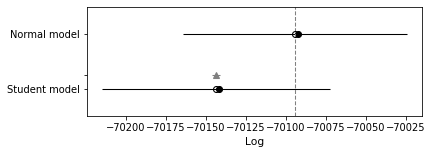

In [48]:
az.plot_compare(w52)

To summarize above comparising, it is safe to assume that normal model is better but only by a small margin. Student model takes the second place for the accuracy.

In [49]:
com1=az.from_cmdstanpy(m2)
com2=az.from_cmdstanpy(m4)

w53=az.compare({"Normal model":com1,"Student model":com2})
w53

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Normal model,0,-70094.293333,1.785230,0.000000,1.0,69.918955,0.000000,False,log
Student model,1,-70143.618418,1.876565,49.325085,0.0,71.208552,2.322487,False,log


As in the previous case, normal model appeared to be superior to a student model in a accuracy sense by quite a small margin, which concludes models effectivity comparasing. 

<AxesSubplot:xlabel='Log'>

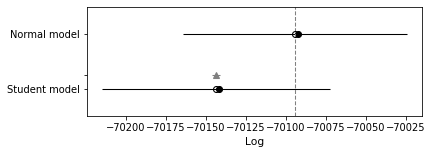

In [50]:
az.plot_compare(w53)

To summarize results of numerous diagnostics and comparasings, the normal model turned out to be more accurate than student model.